In [1]:
import argparse
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import datetime
import time
import copy
from tensorboardX import SummaryWriter  # visual training
from auggi_dataset import AuggiDetectionDataset  # new dataset that uses patches of the img
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import datetime
import csv

In [2]:
########################################################################################################################
## GLOBALS
########################################################################################################################

# CHECK CUDA AVAILABILITY
CUDA_AVAILABLE = torch.cuda.is_available()

# IMAGE DIMENSIONS
IMG_SHAPE = (224, 224)
IMAGE_SIZE = IMG_SHAPE[0]*IMG_SHAPE[1]
IMAGE_WIDTH = IMG_SHAPE[0]
IMAGE_HEIGHT = IMG_SHAPE[1]

# TRAIN PARAMETERS
LOSS_FUNCTION = "Cross Entropy"
EPOCHS = 100
BATCH_SIZE = 6
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.1
IMAGE_PRINT_PERIOD = 1
USE_DATA_AUGMENTATION = True
DATA_AUGMENTATION_UNIFORM_RANDOM_THRESHOLD = 0.5
PERFORM_PARTIAL_FINE_TUNING = True
USE_CONS_BRISTOL = False
NUMBER_LAYERS_FREEZE = 6
NUMBER_SUBCHILD_FREEZE = 0 # number of subchildren (in addition) to freeze
CLASSIFIER_TYPE = "resnet18"
OPTIMIZER = 'SGD'  # 'adam' or 'SGD'

SAVE_MODEL_PATH = 'saved_models/inference_{}_layers_{}_opt_{}_lr_{}_wd_{}.pth'.format(CLASSIFIER_TYPE, 
                                                                 NUMBER_LAYERS_FREEZE,
                                                                OPTIMIZER,
                                                                 LEARNING_RATE,
                                                                 WEIGHT_DECAY)

# calc output layer based on which bristol index using
if USE_CONS_BRISTOL:
    N_LABELS = 3
else:
    N_LABELS = 7

# SET SEED
DEFAULT_RANDOM_SEED = 1
torch.manual_seed(DEFAULT_RANDOM_SEED)
if CUDA_AVAILABLE:
    torch.cuda.manual_seed(DEFAULT_RANDOM_SEED)
    
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
###
## LOAD DATASET
##

# PATH_TO_MANIFEST = "manifest_2019_03_14_train_test_split_20_80.csv"
# PATH_TO_MANIFEST = "manifest_2019_03_14_split_oversampled.csv"  # toggle
PATH_TO_MANIFEST = "manifest_2019_03_21_split_over_undersampled.csv"

# load train data
train_dataset = AuggiDetectionDataset(
    mode="train",
    size=IMG_SHAPE,
    use_augmentation=USE_DATA_AUGMENTATION,
    use_coco_dataset=False,
    path_to_manifest=PATH_TO_MANIFEST
)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# load test data
test_dataset = AuggiDetectionDataset(
    mode="test",
    size=IMG_SHAPE,
    use_augmentation=False,
    use_coco_dataset=False,
    path_to_manifest=PATH_TO_MANIFEST
)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# store both dataloaders here
dataloaders = {
    "train" : train_dataloader,
    "test" : test_dataloader
}
dataset_sizes = {
    "train": train_dataset.__len__(),
    "test": test_dataset.__len__()
}

*******************************
>>> USING DATA AUGMENTATION <<<
*******************************


In [4]:
########################################################################################################################
## SELECT MODEL AND FREEZE SELECT LAYERS
########################################################################################################################

if CLASSIFIER_TYPE == "resnet18":
    model = torchvision.models.resnet18(pretrained=True)
elif CLASSIFIER_TYPE == "resnet34":
    model = torchvision.models.resnet34(pretrained=True)
else:
    raise ValueError("Invalid Resnet Type")

if PERFORM_PARTIAL_FINE_TUNING:
    for param in model.parameters():
        param.requires_grad = True

#################################### freeze layers up to freeze point

# controls the number of subchildren to freeze
SUBCHILDREN_FREEZE_POINT = 1

child_counter = 0
for child in model.children():
    
    # freeze point controls number of main children to freeze
    if child_counter < NUMBER_LAYERS_FREEZE:
        print("child ",child_counter," was frozen")
        for param in child.parameters():
            param.requires_grad = False
    
    # controls subchildren to freeze too
    elif child_counter == NUMBER_LAYERS_FREEZE:
        
        children_of_child_counter = 0
        
        for children_of_child in child.children():
            
            # controls the number of subchildren to freeze
            if children_of_child_counter < NUMBER_SUBCHILD_FREEZE:
                for param in children_of_child.parameters():
                    param.requires_grad = False
                print('child ', children_of_child_counter, 'of child',child_counter,' was frozen')
            else:
                print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
            children_of_child_counter += 1

    else:
        print("child ",child_counter," was not frozen")
    child_counter += 1

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, N_LABELS)

# convert to cuda if needed
if CUDA_AVAILABLE: 
    model.cuda()

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was frozen
child  0 of child 6  was not frozen
child  1 of child 6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


In [5]:
##################

## SELECT OPTIMIZER AND LOSS FUNCTIONS

##################

optimizer = None

# OPTIMIZER (add weight decay here for regularization)
if OPTIMIZER == 'adam':
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# loss function selection
criterion = nn.CrossEntropyLoss()

In [6]:
# log tensorboard
currentDT = datetime.datetime.now()
writer = SummaryWriter('logs/{}'.format(str(currentDT)))

In [7]:
#################################
##  TRAINING PHASE DEFINITION  ##
#################################

def train_phase(train_predictions, train_labels, training_losses, train_acc, total_steps, epoch):
    
    train_running_loss = 0  # track train running loss
    correct = 0
    total = 0

    model.train() # set to train mode

    # load batch images/labels
    for step, (images, bristols, cons_bristols) in enumerate(dataloaders['train']):

        labels = bristols

        # put data onto available device
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(images)  # forward pass
        _, predicted = torch.max(outputs.data, 1)  # retrieve top preds

#             print('pred: {}, actual: {}'.format(predicted.data.numpy(), labels.data.numpy()))

        # append preds and labels for confusion matrix
        train_predictions.extend(predicted.data.numpy())
        train_labels.extend(labels.data.numpy())

        total += labels.size(0)  # add batch size

        correct += (predicted == labels).sum().item()  # calc num correct

        loss = criterion(outputs, labels)  # calc loss
        train_running_loss += loss.item()  # accumulate running loss

        loss.backward()   # backprop
        optimizer.step()  # forward step

        if step % int(total_steps * 0.1) == 0:  # print progress every 10% of training size

#                  print('Ep.{}, Step [{}/{}], Loss: {:.3f}' 
#                 .format(epoch+1, step+1, total_steps, loss.item()))

             print('Ep.{}, Step [{}/{}], Loss: {:.3f}, Pred:{}, True:{}' 
             .format(epoch+1, step+1, total_steps, loss.item(), predicted.data.numpy(), labels.data.numpy()))

    # ---------- statistics for this epoch ------------- #

    # div by num batches to get average
    epoch_train_loss = train_running_loss / len(dataloaders['train'])
    curr_train_acc = correct / total

    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, EPOCHS, epoch_train_loss))
    print()
    print('Train Accuracy: {:.3f} %'.format(100 * curr_train_acc))

    # append the loss/acc after all the steps 
    training_losses.append(epoch_train_loss)
    train_acc.append(curr_train_acc)

    # write to tensorboard
    writer.add_scalar('{}_loss'.format('Train'), epoch_train_loss, epoch)
    writer.add_scalar('{}_accuracy'.format('Train'), curr_train_acc, epoch)

In [8]:
#################################
##  TEST PHASE DEFINITION  ##
#################################

def test_phase(test_predictions, test_labels, test_losses, test_acc, \
                   total_steps, best_per_class_acc, best_per_class_error, \
                   best_test_predictions, best_test_labels, epoch):

    # Track per class test accuracy and error, each epoch
    class_correct = list(0 for i in range(N_LABELS))
    class_total = list(0 for i in range(N_LABELS))
    class_error = list(0 for i in range(N_LABELS))

    per_class_acc = []
    per_class_error = []
    
    batch_preds = []
    batch_labels = []
    
    # evaluate on test data
    model.eval()
    with torch.no_grad():
        test_running_loss = 0  # track test running loss
        correct = 0
        total = 0

        for step, (images, bristols, cons_bristols) in enumerate(dataloaders['test']):

            labels = bristols

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

            correct_compare = (predicted == labels)

            # track batch preds and labels (saving only the best acc)
            batch_preds.extend(predicted.data.numpy())
            batch_labels.extend(labels.data.numpy())
            
            # track all test predictions and labels
            test_predictions.extend(batch_preds)
            test_labels.extend(batch_labels)

            # get per class accuracy too, for this batch
            for i in range(labels.size(0)):  # loop over batch size

                label = labels.data[i]  # curr single label, still tensor
                single_pred = predicted.data[i]  # still a tensor
                class_correct[label] += correct_compare[i].item()
                class_total[label] += 1
                # add error for this label cummulatively

                diff = label.item() - single_pred.item()

                class_error[label] += abs(diff)

                # for evaluating large differences
#                 if diff >= 2:
#                     print('diff {}, pred {}, true {}'.format(diff, single_pred.item(), label.item()))

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # ---------- statistics for this epoch ------------- #

    # div by num batches
    epoch_test_loss = test_running_loss / len(dataloaders['test'])

    # overall accuracy
    curr_test_acc = correct / total

    print('Test Accuracy (Overall): {:.3f} %'.format(100 * curr_test_acc))
    print()
    print('Epoch[{}/{}], Test Loss: {:.4f}'.format(epoch+1, EPOCHS, epoch_test_loss))

    # calc per class accuracy
    for i in range(N_LABELS):

        class_acc = 100 * class_correct[i] / class_total[i]
        per_class_acc.append(class_acc)

        if class_total[i] > 0:
            print('Test Accuracy of class %1d: %2d%% (%2d/%2d)' % (
                i, class_acc,
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of class %1d: N/A (no training examples)' % (i))

    # calc per class error
    for i in range(N_LABELS):

        curr_error = class_error[i] / class_total[i]
        per_class_error.append(curr_error) # append to list

        if class_total[i] > 0:
            print('Test Error of class {}: {:.2f}'.format(
                i, curr_error))
        else:
            print('Test Accuracy of class %1d: N/A (no training examples)' % (i))
    
    # retrieve best max test acc
    curr_max_test_acc = 0
    
    if test_acc:
        curr_max_test_acc = max(test_acc)

    # keep track of best accuracy and best predictions
    # saves model for inference
    if curr_test_acc > curr_max_test_acc:  # check the last test acc
        
        best_test_predictions[:] = batch_preds
        best_test_labels[:] = batch_labels
        
        # save the per class acc and error
        best_per_class_acc[:] = per_class_acc
        best_per_class_error[:] = per_class_error
        
        # save model state dict
        torch.save(model.state_dict(), SAVE_MODEL_PATH)
        
    # append the loss & acc after all the steps 
    test_losses.append(epoch_test_loss)
    test_acc.append(curr_test_acc)

    # write to tensorboard
    writer.add_scalar('{}_loss'.format('Test'), epoch_test_loss, epoch)
    writer.add_scalar('{}_accuracy'.format('Test'), curr_test_acc, epoch)

In [9]:
########################################################################################################################
##           START THE TRAIN AND TEST PHASES         ##############
###################################################################

def run_epochs():
    
    since = time.time()
    total_steps = len(dataloaders['train'])
    
    # track train phase vars
    training_losses = []
    train_acc = []
    
    train_predictions = []  # train predictions
    train_labels = []  # train labels    

    # track test phase vars
    test_losses = []
    test_acc = []    
    
    test_predictions = []  # test predictions
    test_labels = []  # test labels
    
    # store best stats (store for best acc run)
#     best_acc = 0.0
    best_test_predictions = []
    best_test_labels = []    
    best_per_class_acc = []
    best_per_class_error = []
    
    # loop through epochs
    for epoch in range(EPOCHS):

        # call passing references    
        train_phase(train_predictions, train_labels, training_losses, train_acc, total_steps, epoch)
        test_phase(test_predictions, test_labels, test_losses, test_acc, \
                   total_steps, best_per_class_acc, best_per_class_error, \
                   best_test_predictions, best_test_labels, epoch)

    best_acc = max(test_acc)
        
    # finished training, the overall stats
    print()        
    print('The best test accuracy was: {:.2f} %'.format(100*best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return (training_losses, test_losses, train_acc, test_acc, \
            test_predictions, test_labels, best_per_class_acc, best_per_class_error, best_test_predictions, best_test_labels)

In [10]:
# start the train / test phases
training_losses, test_losses, train_acc, test_acc, \
test_predictions, test_labels, best_per_class_acc, best_per_class_error, \
best_test_predictions, best_test_labels = run_epochs()

Ep.1, Step [1/109], Loss: 2.057, Pred:[6 1 1 2 1 0], True:[5 2 4 1 2 2]
Ep.1, Step [11/109], Loss: 2.078, Pred:[2 1 3 2 2 1], True:[3 2 4 4 1 2]
Ep.1, Step [21/109], Loss: 1.869, Pred:[2 2 2 1 3 2], True:[4 3 2 3 4 1]
Ep.1, Step [31/109], Loss: 1.741, Pred:[3 2 2 4 2 3], True:[1 2 4 4 4 0]
Ep.1, Step [41/109], Loss: 1.859, Pred:[3 3 4 4 3 4], True:[2 5 4 3 5 2]
Ep.1, Step [51/109], Loss: 2.336, Pred:[3 3 3 4 4 2], True:[5 0 5 0 3 4]
Ep.1, Step [61/109], Loss: 1.736, Pred:[2 3 5 4 4 2], True:[5 4 5 6 5 2]
Ep.1, Step [71/109], Loss: 1.948, Pred:[3 3 3 5 3 4], True:[1 2 2 4 2 4]
Ep.1, Step [81/109], Loss: 1.772, Pred:[3 5 3 2 5 3], True:[4 3 3 5 6 2]
Ep.1, Step [91/109], Loss: 1.704, Pred:[5 5 3 4 3 5], True:[6 1 3 5 5 2]
Ep.1, Step [101/109], Loss: 1.826, Pred:[2 4 2 3 5 3], True:[4 2 1 4 5 6]
Epoch [1/100], Train Loss: 1.9229

Train Accuracy: 20.339 %
Test Accuracy (Overall): 25.180 %

Epoch[1/100], Test Loss: 1.7615
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of class 1:  0% ( 

Ep.7, Step [1/109], Loss: 1.402, Pred:[3 3 6 3 4 4], True:[2 2 5 3 5 4]
Ep.7, Step [11/109], Loss: 1.871, Pred:[4 5 3 2 3 3], True:[1 5 1 4 6 0]
Ep.7, Step [21/109], Loss: 1.555, Pred:[4 4 2 2 6 3], True:[2 4 4 6 6 4]
Ep.7, Step [31/109], Loss: 1.497, Pred:[3 2 4 4 4 5], True:[0 2 4 4 3 5]
Ep.7, Step [41/109], Loss: 1.447, Pred:[4 5 5 3 4 2], True:[4 5 5 5 2 2]
Ep.7, Step [51/109], Loss: 1.735, Pred:[3 5 5 3 4 3], True:[2 6 5 1 5 4]
Ep.7, Step [61/109], Loss: 1.324, Pred:[5 3 3 3 2 4], True:[5 3 1 3 5 4]
Ep.7, Step [71/109], Loss: 1.913, Pred:[3 3 5 4 3 5], True:[3 2 6 6 4 6]
Ep.7, Step [81/109], Loss: 1.566, Pred:[5 5 3 3 2 4], True:[5 5 3 5 1 5]
Ep.7, Step [91/109], Loss: 1.776, Pred:[2 3 3 3 4 5], True:[1 2 4 0 4 6]
Ep.7, Step [101/109], Loss: 1.684, Pred:[4 6 5 4 2 3], True:[2 3 2 2 2 2]
Epoch [7/100], Train Loss: 1.5980

Train Accuracy: 37.596 %
Test Accuracy (Overall): 41.007 %

Epoch[7/100], Test Loss: 1.4816
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of class 1: 77% ( 

Ep.13, Step [1/109], Loss: 1.228, Pred:[4 4 3 5 4 3], True:[3 2 3 5 4 2]
Ep.13, Step [11/109], Loss: 1.543, Pred:[5 3 2 3 4 2], True:[2 3 4 3 5 1]
Ep.13, Step [21/109], Loss: 1.612, Pred:[4 1 3 3 3 4], True:[4 3 3 3 2 1]
Ep.13, Step [31/109], Loss: 1.562, Pred:[5 3 2 2 3 4], True:[3 4 3 3 2 4]
Ep.13, Step [41/109], Loss: 1.119, Pred:[5 3 3 2 5 6], True:[5 3 3 3 4 4]
Ep.13, Step [51/109], Loss: 1.586, Pred:[3 4 4 5 3 1], True:[3 4 1 4 6 0]
Ep.13, Step [61/109], Loss: 1.533, Pred:[3 4 4 2 3 5], True:[3 6 1 2 0 5]
Ep.13, Step [71/109], Loss: 1.589, Pred:[3 4 2 4 5 4], True:[2 1 2 2 3 4]
Ep.13, Step [81/109], Loss: 1.722, Pred:[5 2 3 4 4 5], True:[0 4 3 4 1 0]
Ep.13, Step [91/109], Loss: 1.534, Pred:[3 2 4 4 4 6], True:[5 2 1 2 3 6]
Ep.13, Step [101/109], Loss: 1.672, Pred:[3 4 2 2 4 1], True:[1 4 3 1 1 1]
Epoch [13/100], Train Loss: 1.4563

Train Accuracy: 42.527 %
Test Accuracy (Overall): 41.727 %

Epoch[13/100], Test Loss: 1.3431
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.19, Step [1/109], Loss: 0.934, Pred:[1 5 4 4 6 3], True:[1 5 4 4 3 4]
Ep.19, Step [11/109], Loss: 0.777, Pred:[3 5 4 3 2 2], True:[3 5 4 3 2 2]
Ep.19, Step [21/109], Loss: 1.021, Pred:[2 4 6 3 4 4], True:[2 4 6 2 1 3]
Ep.19, Step [31/109], Loss: 0.936, Pred:[1 5 4 3 4 4], True:[1 5 4 3 4 4]
Ep.19, Step [41/109], Loss: 1.304, Pred:[6 3 4 2 3 5], True:[2 3 4 1 3 3]
Ep.19, Step [51/109], Loss: 1.413, Pred:[6 6 4 3 4 4], True:[6 5 4 3 0 5]
Ep.19, Step [61/109], Loss: 1.779, Pred:[4 5 4 3 3 2], True:[2 5 2 5 3 2]
Ep.19, Step [71/109], Loss: 1.427, Pred:[4 5 2 3 2 2], True:[5 4 3 2 4 2]
Ep.19, Step [81/109], Loss: 1.403, Pred:[4 6 3 2 2 4], True:[4 0 1 2 2 0]
Ep.19, Step [91/109], Loss: 1.205, Pred:[2 3 3 3 5 1], True:[3 3 2 3 5 0]
Ep.19, Step [101/109], Loss: 1.668, Pred:[4 3 1 5 3 5], True:[5 5 1 2 2 5]
Epoch [19/100], Train Loss: 1.3598

Train Accuracy: 47.766 %
Test Accuracy (Overall): 50.360 %

Epoch[19/100], Test Loss: 1.2098
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.25, Step [1/109], Loss: 0.997, Pred:[2 4 6 4 2 4], True:[3 4 6 4 3 4]
Ep.25, Step [11/109], Loss: 1.448, Pred:[1 3 3 6 4 6], True:[3 4 2 3 4 3]
Ep.25, Step [21/109], Loss: 1.229, Pred:[3 4 6 5 5 3], True:[3 1 6 4 5 2]
Ep.25, Step [31/109], Loss: 1.008, Pred:[1 5 1 3 3 5], True:[2 0 1 3 2 5]
Ep.25, Step [41/109], Loss: 1.348, Pred:[4 4 5 3 3 4], True:[4 4 5 3 0 4]
Ep.25, Step [51/109], Loss: 1.197, Pred:[4 2 6 4 3 5], True:[1 2 6 4 1 6]
Ep.25, Step [61/109], Loss: 1.384, Pred:[3 4 3 4 6 5], True:[3 2 3 4 3 6]
Ep.25, Step [71/109], Loss: 1.377, Pred:[3 1 6 3 4 6], True:[2 1 6 0 5 6]
Ep.25, Step [81/109], Loss: 1.287, Pred:[3 4 3 5 3 2], True:[3 4 3 5 4 5]
Ep.25, Step [91/109], Loss: 0.998, Pred:[1 4 3 4 5 3], True:[0 4 3 4 5 2]
Ep.25, Step [101/109], Loss: 1.111, Pred:[4 5 2 3 6 5], True:[4 5 1 3 1 5]
Epoch [25/100], Train Loss: 1.2483

Train Accuracy: 54.237 %
Test Accuracy (Overall): 53.957 %

Epoch[25/100], Test Loss: 1.1414
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.31, Step [1/109], Loss: 1.067, Pred:[3 5 3 1 5 2], True:[3 3 3 2 5 2]
Ep.31, Step [11/109], Loss: 1.415, Pred:[2 5 4 3 1 3], True:[6 6 5 3 1 6]
Ep.31, Step [21/109], Loss: 1.354, Pred:[3 3 5 5 5 3], True:[3 3 4 5 3 3]
Ep.31, Step [31/109], Loss: 1.156, Pred:[3 5 3 6 1 4], True:[1 5 3 6 1 3]
Ep.31, Step [41/109], Loss: 0.921, Pred:[2 3 4 3 4 5], True:[4 3 4 2 4 5]
Ep.31, Step [51/109], Loss: 1.333, Pred:[3 4 2 2 4 4], True:[3 2 2 5 3 4]
Ep.31, Step [61/109], Loss: 1.142, Pred:[4 5 2 4 2 6], True:[4 5 2 4 5 6]
Ep.31, Step [71/109], Loss: 1.834, Pred:[3 5 5 2 2 5], True:[3 2 3 3 2 3]
Ep.31, Step [81/109], Loss: 1.558, Pred:[2 4 0 4 3 5], True:[5 3 0 4 3 4]
Ep.31, Step [91/109], Loss: 1.309, Pred:[3 6 2 1 4 3], True:[2 6 3 1 5 3]
Ep.31, Step [101/109], Loss: 1.070, Pred:[4 3 6 6 2 1], True:[4 3 6 6 1 5]
Epoch [31/100], Train Loss: 1.1997

Train Accuracy: 50.693 %
Test Accuracy (Overall): 56.115 %

Epoch[31/100], Test Loss: 1.0856
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.37, Step [1/109], Loss: 2.060, Pred:[4 4 4 2 3 2], True:[3 4 5 1 0 4]
Ep.37, Step [11/109], Loss: 1.416, Pred:[4 3 2 5 2 6], True:[4 3 3 4 3 5]
Ep.37, Step [21/109], Loss: 1.225, Pred:[2 3 5 5 2 4], True:[2 4 4 3 3 4]
Ep.37, Step [31/109], Loss: 1.175, Pred:[3 5 4 3 1 3], True:[2 5 4 2 2 6]
Ep.37, Step [41/109], Loss: 0.571, Pred:[5 2 4 6 1 3], True:[6 2 4 6 1 3]
Ep.37, Step [51/109], Loss: 1.144, Pred:[2 0 3 2 3 4], True:[3 0 3 3 3 3]
Ep.37, Step [61/109], Loss: 1.237, Pred:[5 3 2 2 4 2], True:[4 2 2 3 4 2]
Ep.37, Step [71/109], Loss: 1.378, Pred:[5 5 4 3 2 2], True:[5 1 4 3 2 3]
Ep.37, Step [81/109], Loss: 1.538, Pred:[1 2 3 5 3 4], True:[5 2 0 5 5 5]
Ep.37, Step [91/109], Loss: 0.936, Pred:[5 1 3 4 2 4], True:[5 2 2 5 2 4]
Ep.37, Step [101/109], Loss: 1.188, Pred:[0 4 5 3 2 4], True:[0 5 5 3 5 3]
Epoch [37/100], Train Loss: 1.2309

Train Accuracy: 51.310 %
Test Accuracy (Overall): 56.835 %

Epoch[37/100], Test Loss: 1.1134
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.43, Step [1/109], Loss: 1.417, Pred:[2 3 2 5 4 1], True:[2 4 1 4 2 1]
Ep.43, Step [11/109], Loss: 0.816, Pred:[1 4 4 4 6 3], True:[1 5 4 3 6 2]
Ep.43, Step [21/109], Loss: 1.413, Pred:[5 6 2 4 1 5], True:[3 6 4 4 1 2]
Ep.43, Step [31/109], Loss: 1.430, Pred:[3 5 4 2 0 2], True:[2 5 0 1 0 3]
Ep.43, Step [41/109], Loss: 0.971, Pred:[6 3 3 4 4 1], True:[6 3 3 3 4 2]
Ep.43, Step [51/109], Loss: 0.934, Pred:[2 3 5 4 2 5], True:[2 2 5 4 2 5]
Ep.43, Step [61/109], Loss: 1.129, Pred:[2 3 5 3 2 4], True:[2 5 5 4 1 4]
Ep.43, Step [71/109], Loss: 1.135, Pred:[4 3 6 6 1 4], True:[2 4 6 6 2 4]
Ep.43, Step [81/109], Loss: 0.683, Pred:[0 2 3 4 5 4], True:[0 2 3 4 5 4]
Ep.43, Step [91/109], Loss: 0.715, Pred:[5 3 4 2 5 3], True:[5 3 4 3 5 3]
Ep.43, Step [101/109], Loss: 0.942, Pred:[1 4 3 4 2 6], True:[1 5 3 0 2 6]
Epoch [43/100], Train Loss: 1.1398

Train Accuracy: 57.473 %
Test Accuracy (Overall): 60.432 %

Epoch[43/100], Test Loss: 1.0652
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.49, Step [1/109], Loss: 0.713, Pred:[1 4 2 3 5 5], True:[1 2 2 3 4 5]
Ep.49, Step [11/109], Loss: 0.747, Pred:[6 3 4 3 4 1], True:[6 3 4 5 4 1]
Ep.49, Step [21/109], Loss: 1.937, Pred:[3 3 1 5 2 5], True:[5 1 5 5 3 6]
Ep.49, Step [31/109], Loss: 2.062, Pred:[6 3 2 5 1 3], True:[6 2 5 5 5 5]
Ep.49, Step [41/109], Loss: 1.558, Pred:[1 5 3 4 6 4], True:[2 5 1 5 3 3]
Ep.49, Step [51/109], Loss: 1.433, Pred:[2 1 4 5 4 3], True:[2 6 2 1 4 2]
Ep.49, Step [61/109], Loss: 0.920, Pred:[5 4 2 3 5 2], True:[5 4 0 3 4 2]
Ep.49, Step [71/109], Loss: 0.683, Pred:[2 1 4 5 6 3], True:[2 1 5 5 6 3]
Ep.49, Step [81/109], Loss: 0.923, Pred:[1 4 3 6 4 1], True:[1 4 3 6 4 6]
Ep.49, Step [91/109], Loss: 1.246, Pred:[4 4 1 4 6 2], True:[5 2 1 4 6 2]
Ep.49, Step [101/109], Loss: 1.138, Pred:[6 2 4 2 3 5], True:[6 3 4 5 4 5]
Epoch [49/100], Train Loss: 1.1571

Train Accuracy: 55.470 %
Test Accuracy (Overall): 54.676 %

Epoch[49/100], Test Loss: 1.1839
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.55, Step [1/109], Loss: 1.316, Pred:[1 4 2 4 2 6], True:[1 3 2 4 3 3]
Ep.55, Step [11/109], Loss: 0.866, Pred:[3 2 5 1 6 4], True:[3 2 5 1 6 5]
Ep.55, Step [21/109], Loss: 1.124, Pred:[1 3 3 5 5 2], True:[3 4 3 5 5 4]
Ep.55, Step [31/109], Loss: 0.675, Pred:[6 5 4 0 2 2], True:[6 6 4 0 2 2]
Ep.55, Step [41/109], Loss: 1.208, Pred:[4 3 5 5 3 3], True:[4 5 6 2 3 3]
Ep.55, Step [51/109], Loss: 0.758, Pred:[2 3 5 6 6 4], True:[2 1 4 6 6 4]
Ep.55, Step [61/109], Loss: 0.671, Pred:[3 4 5 3 1 5], True:[2 4 5 3 1 5]
Ep.55, Step [71/109], Loss: 1.157, Pred:[3 4 5 5 4 1], True:[3 4 3 5 2 1]
Ep.55, Step [81/109], Loss: 1.032, Pred:[6 3 2 1 4 4], True:[5 2 2 3 4 4]
Ep.55, Step [91/109], Loss: 1.279, Pred:[3 3 2 4 2 5], True:[2 6 3 4 3 5]
Ep.55, Step [101/109], Loss: 1.004, Pred:[4 5 0 5 4 3], True:[4 5 0 6 4 4]
Epoch [55/100], Train Loss: 1.1182

Train Accuracy: 56.394 %
Test Accuracy (Overall): 56.115 %

Epoch[55/100], Test Loss: 1.1297
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.61, Step [1/109], Loss: 1.308, Pred:[2 3 4 5 4 3], True:[2 1 5 3 4 3]
Ep.61, Step [11/109], Loss: 1.271, Pred:[4 5 3 3 6 1], True:[5 5 3 4 6 2]
Ep.61, Step [21/109], Loss: 0.921, Pred:[3 3 1 4 5 4], True:[3 3 1 4 4 4]
Ep.61, Step [31/109], Loss: 1.046, Pred:[4 5 1 3 4 6], True:[4 4 2 4 4 6]
Ep.61, Step [41/109], Loss: 1.289, Pred:[4 1 2 6 5 3], True:[2 2 2 6 5 4]
Ep.61, Step [51/109], Loss: 0.692, Pred:[5 2 6 3 2 4], True:[4 2 6 3 3 4]
Ep.61, Step [61/109], Loss: 1.094, Pred:[4 4 6 4 1 2], True:[2 4 0 3 1 2]
Ep.61, Step [71/109], Loss: 0.941, Pred:[2 2 5 4 3 1], True:[4 2 5 4 3 3]
Ep.61, Step [81/109], Loss: 0.892, Pred:[2 3 3 1 4 5], True:[2 3 2 1 4 5]
Ep.61, Step [91/109], Loss: 1.001, Pred:[4 5 4 3 3 6], True:[4 3 4 3 1 6]
Ep.61, Step [101/109], Loss: 1.204, Pred:[0 4 5 6 3 3], True:[0 3 3 6 3 3]
Epoch [61/100], Train Loss: 1.0633

Train Accuracy: 61.479 %
Test Accuracy (Overall): 52.518 %

Epoch[61/100], Test Loss: 1.1478
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.67, Step [1/109], Loss: 1.286, Pred:[5 6 3 2 4 3], True:[5 6 5 1 5 4]
Ep.67, Step [11/109], Loss: 1.028, Pred:[6 1 5 2 4 4], True:[3 2 5 2 4 4]
Ep.67, Step [21/109], Loss: 0.905, Pred:[4 6 3 3 5 3], True:[2 6 3 3 4 3]
Ep.67, Step [31/109], Loss: 0.712, Pred:[5 6 4 1 5 3], True:[5 6 3 1 5 2]
Ep.67, Step [41/109], Loss: 1.234, Pred:[4 2 3 5 5 2], True:[4 5 3 4 4 2]
Ep.67, Step [51/109], Loss: 1.273, Pred:[4 3 1 5 3 5], True:[4 3 2 3 3 4]
Ep.67, Step [61/109], Loss: 0.849, Pred:[0 0 3 2 3 5], True:[0 0 3 2 2 5]
Ep.67, Step [71/109], Loss: 1.536, Pred:[4 3 4 1 5 3], True:[2 3 2 1 3 0]
Ep.67, Step [81/109], Loss: 0.967, Pred:[4 4 2 2 6 3], True:[1 4 2 2 6 2]
Ep.67, Step [91/109], Loss: 1.291, Pred:[4 3 6 2 4 1], True:[3 3 5 4 5 1]
Ep.67, Step [101/109], Loss: 1.196, Pred:[1 2 3 5 4 2], True:[4 2 3 5 3 4]
Epoch [67/100], Train Loss: 1.1042

Train Accuracy: 58.552 %
Test Accuracy (Overall): 54.676 %

Epoch[67/100], Test Loss: 1.1507
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.73, Step [1/109], Loss: 1.166, Pred:[2 2 5 4 3 4], True:[2 2 5 3 4 4]
Ep.73, Step [11/109], Loss: 0.726, Pred:[4 3 6 4 0 2], True:[3 3 6 4 0 2]
Ep.73, Step [21/109], Loss: 1.059, Pred:[6 5 3 2 3 2], True:[6 5 4 5 1 4]
Ep.73, Step [31/109], Loss: 0.731, Pred:[2 5 3 0 4 3], True:[2 5 2 0 5 3]
Ep.73, Step [41/109], Loss: 1.121, Pred:[5 5 2 6 2 4], True:[5 3 2 6 1 4]
Ep.73, Step [51/109], Loss: 0.985, Pred:[4 2 0 3 4 1], True:[1 2 0 3 2 1]
Ep.73, Step [61/109], Loss: 1.205, Pred:[4 2 6 1 5 4], True:[5 2 6 6 5 5]
Ep.73, Step [71/109], Loss: 0.811, Pred:[4 6 5 2 2 3], True:[5 6 6 2 1 3]
Ep.73, Step [81/109], Loss: 1.544, Pred:[6 1 3 6 4 4], True:[6 5 5 6 4 3]
Ep.73, Step [91/109], Loss: 0.793, Pred:[4 6 5 2 5 3], True:[4 6 5 2 4 2]
Ep.73, Step [101/109], Loss: 0.897, Pred:[5 5 4 3 3 3], True:[5 5 4 3 3 6]
Epoch [73/100], Train Loss: 1.0611

Train Accuracy: 60.401 %
Test Accuracy (Overall): 56.835 %

Epoch[73/100], Test Loss: 1.1491
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.79, Step [1/109], Loss: 0.903, Pred:[6 5 3 5 4 3], True:[6 5 4 4 3 2]
Ep.79, Step [11/109], Loss: 0.693, Pred:[5 2 1 3 4 6], True:[5 2 0 3 4 6]
Ep.79, Step [21/109], Loss: 0.817, Pred:[3 1 2 5 4 3], True:[3 1 4 4 4 3]
Ep.79, Step [31/109], Loss: 0.529, Pred:[6 4 4 1 4 1], True:[6 4 4 1 4 1]
Ep.79, Step [41/109], Loss: 1.295, Pred:[3 2 5 2 4 4], True:[4 3 5 3 4 3]
Ep.79, Step [51/109], Loss: 1.296, Pred:[3 2 4 6 2 4], True:[3 1 4 4 5 4]
Ep.79, Step [61/109], Loss: 0.616, Pred:[4 2 6 4 3 3], True:[4 2 6 4 3 1]
Ep.79, Step [71/109], Loss: 1.339, Pred:[4 4 1 5 3 3], True:[5 4 2 4 4 3]
Ep.79, Step [81/109], Loss: 1.014, Pred:[5 2 4 1 3 4], True:[5 1 4 1 2 4]
Ep.79, Step [91/109], Loss: 1.060, Pred:[2 4 5 0 2 3], True:[2 3 3 0 2 3]
Ep.79, Step [101/109], Loss: 0.747, Pred:[4 3 5 2 3 1], True:[5 3 5 1 3 1]
Epoch [79/100], Train Loss: 0.9916

Train Accuracy: 62.096 %
Test Accuracy (Overall): 51.079 %

Epoch[79/100], Test Loss: 1.2292
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.85, Step [1/109], Loss: 0.669, Pred:[3 0 3 5 2 2], True:[3 0 2 5 2 2]
Ep.85, Step [11/109], Loss: 0.692, Pred:[3 3 6 3 4 1], True:[3 3 6 3 5 1]
Ep.85, Step [21/109], Loss: 0.424, Pred:[3 1 5 2 6 4], True:[3 1 5 2 6 4]
Ep.85, Step [31/109], Loss: 1.328, Pred:[2 4 3 1 3 5], True:[2 5 3 1 2 4]
Ep.85, Step [41/109], Loss: 0.932, Pred:[4 6 2 4 5 3], True:[4 6 2 4 5 1]
Ep.85, Step [51/109], Loss: 0.793, Pred:[6 4 2 1 3 1], True:[6 4 3 2 3 1]
Ep.85, Step [61/109], Loss: 1.107, Pred:[5 2 2 4 3 6], True:[2 2 2 4 3 1]
Ep.85, Step [71/109], Loss: 1.510, Pred:[2 2 1 4 4 0], True:[5 6 0 2 5 0]
Ep.85, Step [81/109], Loss: 0.811, Pred:[5 4 3 2 4 1], True:[5 5 3 3 5 1]
Ep.85, Step [91/109], Loss: 1.124, Pred:[6 5 4 4 3 2], True:[6 6 3 4 3 2]
Ep.85, Step [101/109], Loss: 1.095, Pred:[1 5 3 1 2 4], True:[1 4 2 1 2 4]
Epoch [85/100], Train Loss: 1.0527

Train Accuracy: 61.171 %
Test Accuracy (Overall): 54.676 %

Epoch[85/100], Test Loss: 1.1560
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.91, Step [1/109], Loss: 0.672, Pred:[3 5 3 5 3 1], True:[3 5 2 5 3 1]
Ep.91, Step [11/109], Loss: 0.962, Pred:[3 4 6 3 4 1], True:[3 4 6 3 3 4]
Ep.91, Step [21/109], Loss: 0.797, Pred:[5 5 3 2 3 2], True:[5 5 2 2 4 2]
Ep.91, Step [31/109], Loss: 1.072, Pred:[5 2 5 4 2 3], True:[5 2 3 4 2 1]
Ep.91, Step [41/109], Loss: 1.529, Pred:[6 3 1 2 3 5], True:[2 4 2 3 3 4]
Ep.91, Step [51/109], Loss: 1.270, Pred:[6 4 1 1 5 3], True:[6 6 1 1 5 5]
Ep.91, Step [61/109], Loss: 0.662, Pred:[0 1 5 3 3 2], True:[0 1 5 3 2 2]
Ep.91, Step [71/109], Loss: 0.928, Pred:[3 2 4 1 5 6], True:[3 2 5 1 6 6]
Ep.91, Step [81/109], Loss: 1.478, Pred:[5 2 3 6 3 4], True:[3 2 3 4 3 4]
Ep.91, Step [91/109], Loss: 0.656, Pred:[5 2 5 3 1 3], True:[5 2 6 3 1 3]
Ep.91, Step [101/109], Loss: 1.417, Pred:[4 6 5 3 4 2], True:[5 3 5 3 4 3]
Epoch [91/100], Train Loss: 1.0418

Train Accuracy: 61.787 %
Test Accuracy (Overall): 51.799 %

Epoch[91/100], Test Loss: 1.1681
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

Ep.97, Step [1/109], Loss: 0.707, Pred:[5 4 6 3 1 5], True:[5 4 6 3 2 5]
Ep.97, Step [11/109], Loss: 1.283, Pred:[4 3 5 4 2 2], True:[4 3 2 2 2 3]
Ep.97, Step [21/109], Loss: 0.544, Pred:[6 5 3 4 2 4], True:[6 5 3 4 3 4]
Ep.97, Step [31/109], Loss: 1.007, Pred:[2 4 6 4 4 1], True:[2 3 6 4 2 1]
Ep.97, Step [41/109], Loss: 0.938, Pred:[2 5 6 5 4 3], True:[2 5 5 5 3 3]
Ep.97, Step [51/109], Loss: 0.647, Pred:[2 5 3 1 3 4], True:[1 5 3 1 3 4]
Ep.97, Step [61/109], Loss: 0.755, Pred:[3 3 2 5 3 6], True:[3 3 2 4 3 6]
Ep.97, Step [71/109], Loss: 1.068, Pred:[3 4 3 6 1 2], True:[3 4 4 3 1 1]
Ep.97, Step [81/109], Loss: 1.335, Pred:[5 6 4 5 3 3], True:[3 2 3 5 3 4]
Ep.97, Step [91/109], Loss: 1.215, Pred:[1 5 2 2 3 4], True:[2 2 3 2 3 5]
Ep.97, Step [101/109], Loss: 0.554, Pred:[6 3 2 5 0 3], True:[6 2 2 5 0 3]
Epoch [97/100], Train Loss: 0.9688

Train Accuracy: 66.256 %
Test Accuracy (Overall): 56.115 %

Epoch[97/100], Test Loss: 1.1378
Test Accuracy of class 0:  0% ( 0/ 1)
Test Accuracy of cl

In [11]:
# save the training log of hyperparameters and best test acc
training_log = {
    "classifier":CLASSIFIER_TYPE,
    "optimizer":OPTIMIZER,
    "loss_function": LOSS_FUNCTION,
    "batch_size":BATCH_SIZE,
    "lr":LEARNING_RATE,
    "momentum":MOMENTUM,
    "weight_decay":WEIGHT_DECAY,
    "epochs":EPOCHS,
    "augmentation":USE_DATA_AUGMENTATION,
    "consolidated_bristol":USE_CONS_BRISTOL,
    "layers_frozen":NUMBER_LAYERS_FREEZE,
    "best_test_accuracy":max(test_acc), # store best test acc
    "best_per_class_acc":best_per_class_acc,
    "best_per_class_error":best_per_class_error,
    "saved_model_path":SAVE_MODEL_PATH
}

# print log to csv
csv_name = SAVE_MODEL_PATH.split('.')[0]
with open(csv_name + ".csv", mode='w') as out_file:
    out_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for key, val in training_log.items():
        out_writer.writerow([key, val])

In [12]:
######################################################################
#######   POST PROCESSING AFTER TRAINING   ###########################
####################################################################


def plot_graph(train_losses, test_losses, train_acc, test_acc):
    # plot graph
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.legend(loc='best')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Cross entropy)")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.legend(loc='best')
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig('resnet_training_graph.png')

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

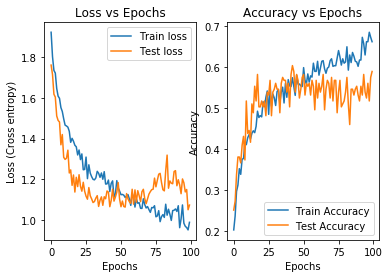

In [14]:
# plot and save training graph
plot_graph(training_losses, test_losses, train_acc, test_acc)

Normalized confusion matrix
[[0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.44 0.22 0.11 0.11 0.11 0.  ]
 [0.   0.1  0.6  0.27 0.   0.   0.03]
 [0.   0.03 0.18 0.7  0.09 0.   0.  ]
 [0.   0.03 0.03 0.19 0.56 0.19 0.  ]
 [0.   0.04 0.   0.   0.33 0.56 0.07]
 [0.   0.   0.   0.14 0.   0.   0.86]]


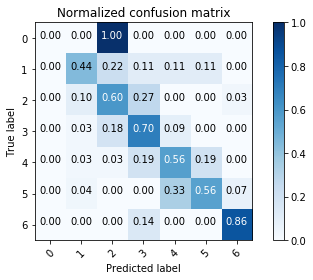

In [15]:
# create confusion matrix and plot
cnf_matrix = confusion_matrix(best_test_labels, best_test_predictions)
np.set_printoptions(precision=2)

class_names = ['0', '1', '2', '3', '4', '5', '6']

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 